In [546]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import yfinance as yf
pd.set_option('max_rows',20)

### get data


#### kospi

In [272]:
kospiBefore1998 = fdr.DataReader('KS11', start='1980', end='1998')
kospiBefore1998 = kospiBefore1998#.reset_index()

kospiAfter1998 = fdr.DataReader('KS11', start='1997', end='2017')
kospiAfter1998 = kospiAfter1998#.reset_index()

kospiAfter2016 = fdr.DataReader('KS11', start='2016', end=None)
kospiAfter2016 = kospiAfter2016#.reset_index()

In [273]:
_ = pd.concat([kospiBefore1998, kospiAfter1998])
kospi = pd.concat([_, kospiAfter2016])

In [274]:
kospi = kospi.drop_duplicates()

In [275]:
kospi['overNightChange'] = kospi['Open'].shift(-1) / kospi['Close'] - 1

In [276]:
kospi = kospi.reset_index()

In [277]:
kospiFirstDate = str(kospi['Date'].iloc[0])

In [278]:
kospi

,Date,Close,Open,High,Low,Volume,Change,overNightChange
0,1981-05-01,123.60,123.60,123.60,123.60,3330000.0,0.0098,-0.000809
1,1981-05-02,123.50,123.50,123.50,123.50,2040000.0,-0.0008,-0.023482
2,1981-05-04,120.60,120.60,120.60,120.60,1930000.0,-0.0235,0.000829
...,...,...,...,...,...,...,...,...
10325,2019-11-05,2142.64,2133.66,2143.12,2128.70,394380.0,0.0058,0.000023
10326,2019-11-06,2144.15,2142.69,2156.23,2138.83,402500.0,0.0007,-0.001446
10327,2019-11-07,2144.29,2141.05,2147.01,2135.45,417910.0,0.0001,NaN


#### snp500

In [298]:
snp = yf.Ticker("^GSPC")
snp = snp.history(period="max")

In [299]:
snp = snp.shift(1)

In [300]:
snp = snp[snp.index >= kospiFirstDate]

In [301]:
snp = snp.reset_index()

In [302]:
snp = snp[snp.columns[:-2]]

In [303]:
# snp['Change'] = snp['Close'].shift(1) / snp['Close'].shift(0) - 1

In [304]:
snp['Change'] = (snp['Close'].shift(0) - snp['Close'].shift(1)) / snp['Close'].shift(1)

#### krw/usd

### wrangle

#### left merge

In [420]:
dates = pd.concat([snp['Date'], kospi['Date']])

In [421]:
dates = dates.drop_duplicates()

In [422]:
dates = dates.sort_values()

In [423]:
dates = dates.reset_index(drop=True)

In [424]:
df = pd.DataFrame([])

In [425]:
df['Date'] = dates

In [426]:
df = df.merge(kospi, how='left')

In [427]:
df = pd.merge(left=snp, right=df, on='Date', suffixes=['_snp','_kospi'])

#### missing value process

In [429]:
df = df.fillna(method='ffill')

df = df.fillna(method='bfill')

#### more columns

In [430]:
df['Range_snp'] = _ =(df['Close_snp'] - df['Open_snp']) / (df['High_snp'] - df['Low_snp'])

In [431]:
df['Close/Open_snp'] = df['Close_snp'] / df['Open_snp'] - 1

In [432]:
df['High/Low_snp'] = df['High_snp'] / df['Low_snp'] - 1

In [433]:
df['rolling(5)_snp'] = df['Close_snp'].rolling(5).mean()

In [434]:
df['rolling(10)_snp'] = df['Close_snp'].rolling(10).mean()

In [435]:
df['rolling(20)_snp'] = df['Close_snp'].rolling(20).mean()

In [436]:
df['rolling(60)_snp'] = df['Close_snp'].rolling(60).mean()

In [442]:
df['Disparity(5)_snp'] = df['Close_snp'] / df['rolling(5)_snp']

In [443]:
df['Disparity(10)_snp'] = df['Close_snp'] / df['rolling(10)_snp']

In [444]:
df['Disparity(20)_snp'] = df['Close_snp'] / df['rolling(20)_snp']

In [445]:
df['Disparity(60)_snp'] = df['Close_snp'] / df['rolling(60)_snp']

In [446]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

### modeling

In [453]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

In [454]:
df['overNightChangeBinary'] = df['overNightChange'].apply(lambda x: 1 if x >= 0 else 0)
df['Change_kospiBinary'] = df['Change_kospi'].apply(lambda x: 1 if x >= 0 else 0)

In [455]:
print('up / down ratio is')
sum(df['Change_kospiBinary']) / len(df)

up / down ratio is


0.5211035618694667

In [456]:
testSetRatio = 0.1
cuttingPoint = int(len(df) * (1-testSetRatio))

In [457]:
dfTest = df.iloc[cuttingPoint:,:]
dfTrainValid = df.iloc[:cuttingPoint,:]

In [458]:
features = [i for i in list(df.columns) if 'snp' in i]

In [486]:
df

,Date,Open_snp,High_snp,Low_snp,Close_snp,Volume_snp,Change_snp,Close_kospi,Open_kospi,High_kospi,...,rolling(5)_snp,rolling(10)_snp,rolling(20)_snp,rolling(60)_snp,Disparity(5)_snp,Disparity(10)_snp,Disparity(20)_snp,Disparity(60)_snp,overNightChangeBinary,Change_kospiBinary
0,1981-05-01,133.050003,134.440002,131.850006,132.809998,4.797000e+07,-0.000678,123.60,123.60,123.60,...,131.460001,131.161002,131.738000,131.152334,1.010269,1.012572,1.008137,1.012639,0,1
1,1981-05-04,132.809998,134.169998,131.429993,132.720001,4.836000e+07,-0.000678,120.60,120.60,120.60,...,131.460001,131.161002,131.738000,131.152334,1.009585,1.011886,1.007454,1.011953,1,0
2,1981-05-05,131.779999,131.779999,129.610001,130.669998,4.043000e+07,-0.015446,120.60,120.60,120.60,...,131.460001,131.161002,131.738000,131.152334,0.993991,0.996256,0.991893,0.996322,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9711,2019-11-04,3050.719971,3066.949951,3050.719971,3066.909912,3.930200e+09,0.009662,2130.24,2111.32,2130.83,...,3045.509961,3026.761987,2993.146973,2958.437988,1.007027,1.013264,1.024644,1.036665,1,1
9712,2019-11-05,3078.959961,3085.199951,3074.870117,3078.270020,4.146850e+09,0.003704,2142.64,2133.66,2143.12,...,3053.279980,3033.916992,3000.120972,2961.098324,1.008185,1.014619,1.026049,1.039570,1,1
9713,2019-11-06,3080.800049,3083.949951,3072.149902,3074.620117,4.486130e+09,-0.001186,2144.15,2142.69,2156.23,...,3060.826025,3041.780005,3009.198975,2964.296993,1.004507,1.010796,1.021740,1.037217,0,1


#### targetColumn = overNightChange

In [459]:
targetColumn = 'overNightChangeBinary'

In [460]:
trainX, validX, trainy, validy = train_test_split(dfTrainValid[features], dfTrainValid[targetColumn], test_size=0.3)

In [461]:
model = CatBoostClassifier(iterations=500, learning_rate=0.1,
                            eval_metric='AUC', # [ RMSE , R2 ]
                            loss_function='CrossEntropy',
                            use_best_model=True,
                            max_depth=4,
                            #depth=6,
                            bagging_temperature = 0.2,
                            metric_period = 25)

In [465]:
model.fit(
    trainX, trainy,
    # cat_features=categorical_features_indices,
    verbose=True,
    plot=True, # NOTE: does not work for classifier
    eval_set=(validX, validy)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5195680	best: 0.5195680 (0)	total: 23.7ms	remaining: 11.8s
25:	test: 0.5318091	best: 0.5318091 (25)	total: 412ms	remaining: 7.51s
50:	test: 0.5388570	best: 0.5388570 (50)	total: 718ms	remaining: 6.32s
75:	test: 0.5401692	best: 0.5401692 (75)	total: 1.02s	remaining: 5.7s
100:	test: 0.5393098	best: 0.5401692 (75)	total: 1.32s	remaining: 5.22s
125:	test: 0.5405541	best: 0.5405541 (125)	total: 1.63s	remaining: 4.82s
150:	test: 0.5404576	best: 0.5405541 (125)	total: 1.92s	remaining: 4.43s
175:	test: 0.5414633	best: 0.5414633 (175)	total: 2.21s	remaining: 4.08s
200:	test: 0.5454023	best: 0.5454023 (200)	total: 2.5s	remaining: 3.73s
225:	test: 0.5446253	best: 0.5454023 (200)	total: 2.69s	remaining: 3.27s
250:	test: 0.5435939	best: 0.5454023 (200)	total: 2.98s	remaining: 2.95s
275:	test: 0.5457931	best: 0.5457931 (275)	total: 3.41s	remaining: 2.77s
300:	test: 0.5460236	best: 0.5460236 (300)	total: 3.8s	remaining: 2.51s
325:	test: 0.5461745	best: 0.5461745 (325)	total: 4.14s	remainin

In [466]:
predicted = model.predict(dfTest[features])

In [467]:
print('accuracy is')
sum(predicted == dfTest[targetColumn]) / len(predicted)

accuracy is


0.5216049382716049

#### targetColumn = kospi Change

In [468]:
targetColumn = 'Change_kospiBinary'

In [469]:
trainX, validX, trainy, validy = train_test_split(dfTrainValid[features], dfTrainValid[targetColumn], test_size=0.3)

In [470]:
model = CatBoostClassifier(iterations=500, learning_rate=0.1,
                            eval_metric='AUC', # [ RMSE , R2 ]
                            loss_function='CrossEntropy',
                            use_best_model=True,
                            max_depth=6,
                            #depth=6,
                            bagging_temperature = 0.2,
                            metric_period = 25)

In [471]:
model.fit(
    trainX, trainy,
    # cat_features=categorical_features_indices,
    verbose=True,
    plot=True, # NOTE: does not work for classifier
    eval_set=(validX, validy)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5802272	best: 0.5802272 (0)	total: 24.5ms	remaining: 12.2s
25:	test: 0.6036164	best: 0.6036164 (25)	total: 483ms	remaining: 8.81s
50:	test: 0.6058743	best: 0.6058743 (50)	total: 741ms	remaining: 6.52s
75:	test: 0.6030966	best: 0.6058743 (50)	total: 991ms	remaining: 5.53s
100:	test: 0.6045158	best: 0.6058743 (50)	total: 1.34s	remaining: 5.29s
125:	test: 0.6003113	best: 0.6058743 (50)	total: 1.7s	remaining: 5.03s
150:	test: 0.5937338	best: 0.6058743 (50)	total: 2.05s	remaining: 4.74s
175:	test: 0.5950876	best: 0.6058743 (50)	total: 2.41s	remaining: 4.43s
200:	test: 0.5959245	best: 0.6058743 (50)	total: 2.73s	remaining: 4.06s
225:	test: 0.5917989	best: 0.6058743 (50)	total: 2.91s	remaining: 3.53s
250:	test: 0.5898289	best: 0.6058743 (50)	total: 3.22s	remaining: 3.19s
275:	test: 0.5844971	best: 0.6058743 (50)	total: 3.56s	remaining: 2.89s
300:	test: 0.5830779	best: 0.6058743 (50)	total: 3.89s	remaining: 2.57s
325:	test: 0.5823537	best: 0.6058743 (50)	total: 4.22s	remaining: 2.25

In [476]:
predicted = model.predict(dfTest[features])

In [477]:
print('accuracy is')
sum(predicted == dfTest[targetColumn]) / len(predicted)

accuracy is


0.5925925925925926

### result

In [492]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
def jitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [479]:
dfTestPredicted = dfTest.copy()

In [480]:
dfTestPredicted['predicted'] = model.predict(dfTestPredicted[features]).astype(int)

In [481]:
dfTestPredicted['predictedProbaToBeOne'] = np.array([i[1] for i in model.predict_proba(dfTestPredicted[features])])

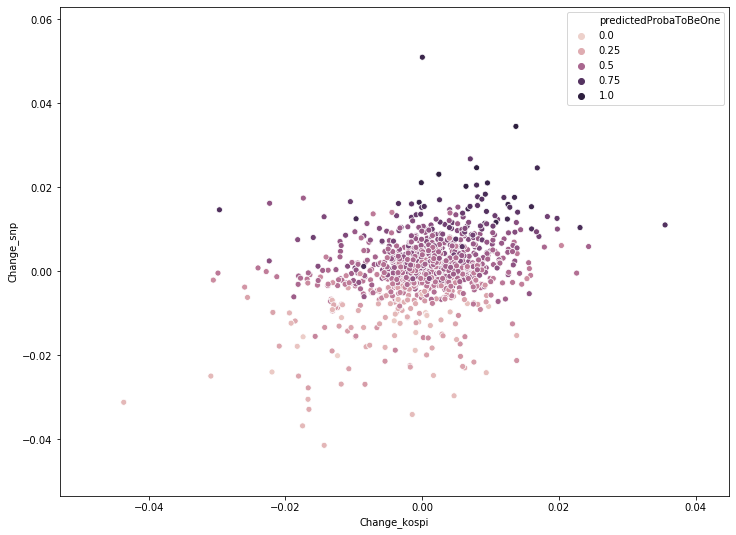

In [483]:
plt.figure(figsize=(12, 9))
sns.scatterplot(x=jitt(dfTestPredicted['Change_kospi']),
                y=jitt(dfTestPredicted['Change_snp']),
                hue=dfTestPredicted['predictedProbaToBeOne'])

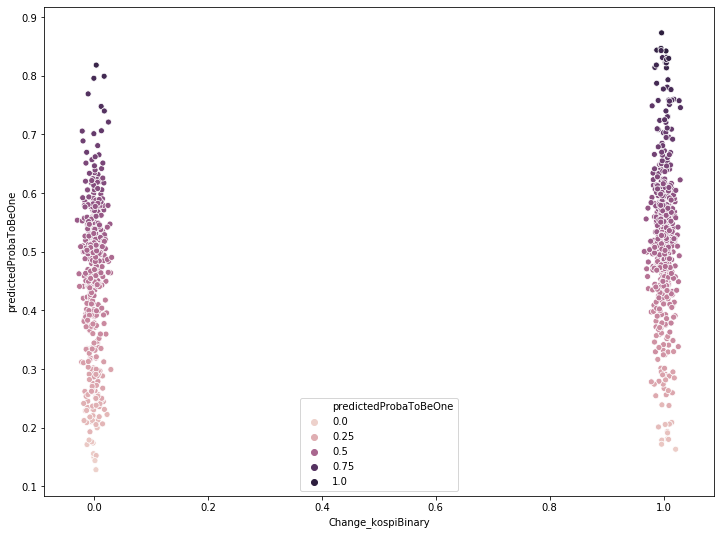

In [485]:
plt.figure(figsize=(12, 9))
sns.scatterplot(x=jitt(dfTestPredicted['Change_kospiBinary']),
                y=jitt(dfTestPredicted['predictedProbaToBeOne']),
               hue=jitt(dfTestPredicted['predictedProbaToBeOne'])
               )

#### tree on prediction

In [548]:
dfTestPredicted

,Date,Open_snp,High_snp,Low_snp,Close_snp,Volume_snp,Change_snp,Close_kospi,Open_kospi,High_kospi,...,rolling(20)_snp,rolling(60)_snp,Disparity(5)_snp,Disparity(10)_snp,Disparity(20)_snp,Disparity(60)_snp,overNightChangeBinary,Change_kospiBinary,predicted,predictedProbaToBeOne
8742,2015-12-29,2057.770020,2057.770020,2044.199951,2056.500000,2.492510e+09,-0.002179,1966.31,1956.49,1968.57,...,2054.225006,2053.974668,1.003964,1.006718,1.001107,1.001229,1,1,1,0.531666
8743,2015-12-30,2060.540039,2081.560059,2060.540039,2078.360107,2.542000e+09,0.010630,1961.31,1973.03,1974.67,...,2054.122516,2056.091337,1.009000,1.014617,1.011799,1.010831,0,0,1,0.680442
8744,2015-12-31,2077.340088,2077.340088,2061.969971,2063.360107,2.367430e+09,-0.007217,1961.31,1973.03,1974.67,...,2052.159027,2057.363171,0.999351,1.006314,1.005458,1.002915,0,0,0,0.302444
8745,2016-01-04,2060.590088,2062.540039,2043.619995,2043.939941,2.655330e+09,-0.009412,1918.76,1954.47,1954.52,...,2050.380524,2058.430170,0.991900,0.998261,0.996859,0.992961,0,0,0,0.280222
8746,2016-01-05,2038.199951,2038.199951,1989.680054,2012.660034,4.304880e+09,-0.015304,1930.53,1911.93,1937.57,...,2048.532520,2058.710671,0.981324,0.984389,0.982489,0.977631,1,1,0,0.347002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9709,2019-10-31,3039.739990,3050.100098,3025.959961,3046.770020,3.776030e+09,0.003253,2083.48,2089.22,2103.71,...,2981.055469,2953.731323,1.005142,1.010628,1.022044,1.031499,1,1,0,0.470011
9710,2019-11-01,3046.899902,3046.899902,3023.189941,3037.560059,4.139280e+09,-0.003023,2100.20,2084.79,2100.42,...,2987.401978,2956.290991,1.000304,1.006251,1.016790,1.027490,1,1,0,0.395855
9711,2019-11-04,3050.719971,3066.949951,3050.719971,3066.909912,3.930200e+09,0.009662,2130.24,2111.32,2130.83,...,2993.146973,2958.437988,1.007027,1.013264,1.024644,1.036665,1,1,1,0.546938
9712,2019-11-05,3078.959961,3085.199951,3074.870117,3078.270020,4.146850e+09,0.003704,2142.64,2133.66,2143.12,...,3000.120972,2961.098324,1.008185,1.014619,1.026049,1.039570,1,1,0,0.471801


In [525]:
targetColumn = 'predicted'

In [526]:
dtc = DecisionTreeClassifier(min_samples_split=30, 
                            max_depth=4, 
                            min_samples_leaf=10)

In [527]:
dtc.fit(dfTestPredicted[features], dfTestPredicted[targetColumn])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

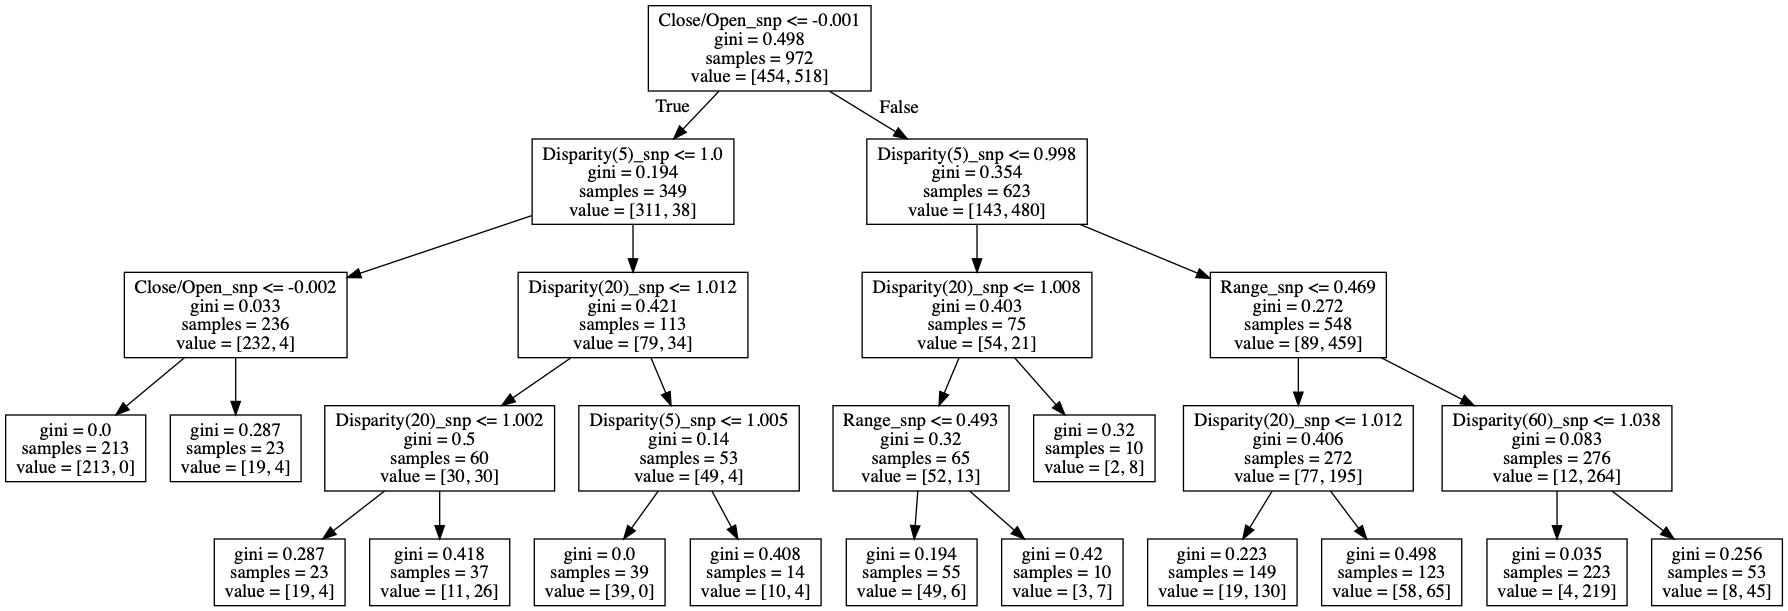

In [528]:
from IPython.display import Image  
import pydotplus
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(dtc, out_file=None, feature_names=features)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [533]:
features

['Open_snp',
 'High_snp',
 'Low_snp',
 'Close_snp',
 'Volume_snp',
 'Change_snp',
 'Range_snp',
 'Close/Open_snp',
 'High/Low_snp',
 'rolling(5)_snp',
 'rolling(10)_snp',
 'rolling(20)_snp',
 'rolling(60)_snp',
 'Disparity(5)_snp',
 'Disparity(10)_snp',
 'Disparity(20)_snp',
 'Disparity(60)_snp']

In [543]:
_ = pd.DataFrame(dtc.feature_importances_)

In [544]:
_.index = features

In [547]:
_

,0
Open_snp,0.000000
High_snp,0.000000
Low_snp,0.000000
Close_snp,0.000000
Volume_snp,0.000000
Change_snp,0.000000
Range_snp,0.068585
Close/Open_snp,0.624601
High/Low_snp,0.000000
rolling(5)_snp,0.000000
